## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [16]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [17]:
train, test = keras.datasets.cifar10.load_data()

In [18]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [19]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [20]:
from keras.regularizers import l1, l2
from keras.layers import BatchNormalization,Dropout


"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128, 64], l2_ratio=1e-4, dropout=0.2):
    input_layer = keras.layers.Input(input_shape)
    X = BatchNormalization()(input_layer)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(X)
            x = Dropout(dropout)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
            x = Dropout(dropout)(x)
    
    x = BatchNormalization()(x)
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [21]:
"""Code Here
設定超參數
"""
## 超參數設定
LEARNING_RATE = 0.01
EPOCHS = 50
BATCH_SIZE = 128
MOMENTUM = 0.95
DROPOUT = 0.5
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [22]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio, dropout=DROPOUT)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128

Epoch 46/50
50000/50000 [==============================] - 5s 104us/step - loss: 2.1176 - acc: 0.3254 - val_loss: 1.9552 - val_acc: 0.3993
Epoch 47/50
50000/50000 [==============================] - 5s 99us/step - loss: 2.1152 - acc: 0.3251 - val_loss: 1.9854 - val_acc: 0.3707
Epoch 48/50
50000/50000 [==============================] - 5s 99us/step - loss: 2.1149 - acc: 0.3266 - val_loss: 1.9906 - val_acc: 0.3862
Epoch 49/50
50000/50000 [==============================] - 5s 98us/step - loss: 2.1166 - acc: 0.3266 - val_loss: 1.9771 - val_acc: 0.3800
Epoch 50/50
50000/50000 [==============================] - 5s 97us/step - loss: 2.1145 - acc: 0.3218 - val_loss: 1.9939 - val_acc: 0.3571
Experiment with Regulizer = 0.000100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_no

Epoch 41/50
50000/50000 [==============================] - 5s 100us/step - loss: 1.4710 - acc: 0.5379 - val_loss: 1.4452 - val_acc: 0.5449
Epoch 42/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.4680 - acc: 0.5408 - val_loss: 1.4422 - val_acc: 0.5387
Epoch 43/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.4635 - acc: 0.5422 - val_loss: 1.4308 - val_acc: 0.5478
Epoch 44/50
50000/50000 [==============================] - 5s 102us/step - loss: 1.4574 - acc: 0.5457 - val_loss: 1.4354 - val_acc: 0.5418
Epoch 45/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.4515 - acc: 0.5480 - val_loss: 1.4265 - val_acc: 0.5461
Epoch 46/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.4424 - acc: 0.5542 - val_loss: 1.4264 - val_acc: 0.5452
Epoch 47/50
50000/50000 [==============================] - 5s 100us/step - loss: 1.4549 - acc: 0.5505 - val_loss: 1.4353 - val_acc: 0.5459
Epoch 48/50
50000/50000 [==

50000/50000 [==============================] - 5s 107us/step - loss: 1.3571 - acc: 0.5217 - val_loss: 1.3258 - val_acc: 0.5361
Epoch 36/50
50000/50000 [==============================] - 5s 104us/step - loss: 1.3408 - acc: 0.5303 - val_loss: 1.3256 - val_acc: 0.5361
Epoch 37/50
50000/50000 [==============================] - 5s 107us/step - loss: 1.3440 - acc: 0.5304 - val_loss: 1.3196 - val_acc: 0.5308
Epoch 38/50
50000/50000 [==============================] - 5s 99us/step - loss: 1.3384 - acc: 0.5313 - val_loss: 1.3158 - val_acc: 0.5319
Epoch 39/50
50000/50000 [==============================] - 5s 97us/step - loss: 1.3270 - acc: 0.5345 - val_loss: 1.3143 - val_acc: 0.5264
Epoch 40/50
50000/50000 [==============================] - 5s 97us/step - loss: 1.3212 - acc: 0.5367 - val_loss: 1.3042 - val_acc: 0.5332
Epoch 41/50
50000/50000 [==============================] - 5s 97us/step - loss: 1.3083 - acc: 0.5418 - val_loss: 1.3128 - val_acc: 0.5377
Epoch 42/50
50000/50000 [==================

Epoch 30/50
50000/50000 [==============================] - 5s 102us/step - loss: 1.3918 - acc: 0.5086 - val_loss: 1.3424 - val_acc: 0.5205
Epoch 31/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.3905 - acc: 0.5117 - val_loss: 1.3421 - val_acc: 0.5184
Epoch 32/50
50000/50000 [==============================] - 5s 105us/step - loss: 1.3795 - acc: 0.5162 - val_loss: 1.3292 - val_acc: 0.5289
Epoch 33/50
50000/50000 [==============================] - 5s 100us/step - loss: 1.3629 - acc: 0.5216 - val_loss: 1.3180 - val_acc: 0.5335
Epoch 34/50
50000/50000 [==============================] - 5s 100us/step - loss: 1.3643 - acc: 0.5202 - val_loss: 1.3181 - val_acc: 0.5304
Epoch 35/50
50000/50000 [==============================] - 5s 99us/step - loss: 1.3580 - acc: 0.5221 - val_loss: 1.3197 - val_acc: 0.5416
Epoch 36/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.3483 - acc: 0.5249 - val_loss: 1.3099 - val_acc: 0.5399
Epoch 37/50
50000/50000 [===

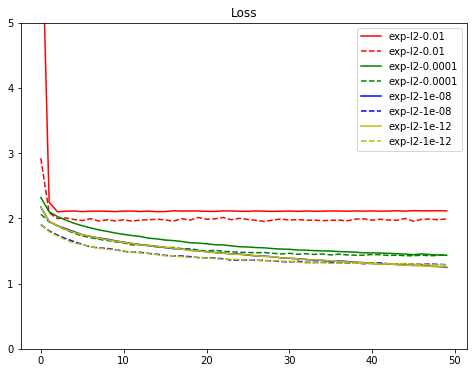

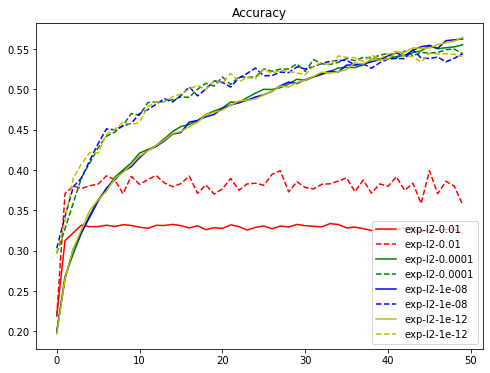

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()